In [45]:
using MAT
using Plots
using Images
using Distributed


pyplot()
file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)


In [46]:
procs()

1-element Vector{Int64}:
 1

In [47]:
workers()

1-element Vector{Int64}:
 1

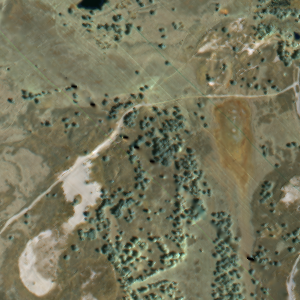

In [48]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

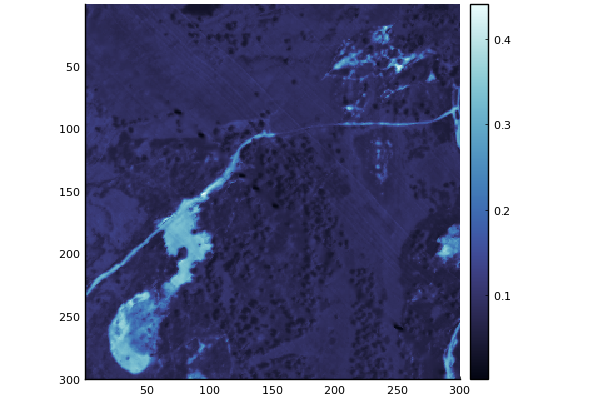

In [49]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,15],aspect_ratio=1, yflip = true,c=:ice)

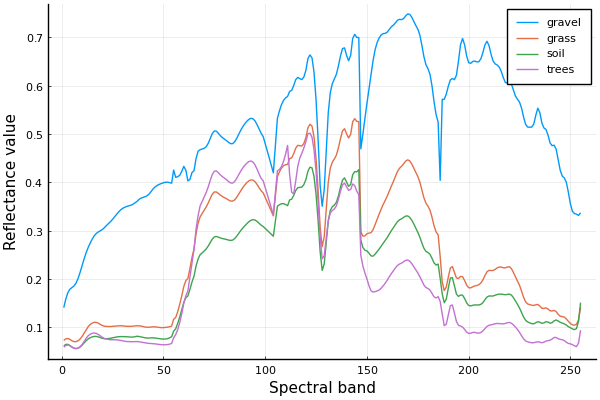

In [50]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [51]:
using LinearAlgebra
@everywhere f(S,A,X) = 1/2 * norm(X - S*A,2);
@everywhere ∇f(S,A,X)  = 2 * transpose(S)*S*A .- transpose(S)*X; # I only take a derivative with respect to A because I believe it's the only variable

# Parameters

In [52]:
height = 300;
width = 300;
precision = 10e-8;
max_iter = 100;
step_size = 2/opnorm(transpose(sources)*sources);

#########################################

N = height*width
A = reshape([rand(4,1) for i=1:N],1,N);

img_small = img[1:height,1:width,:]; 

In [53]:
img_small = permutedims(img_small, (3,1,2));
img_small_flatt = reshape(img_small, 255, N);
img_small_para = reshape([img_small_flatt[:,i] for i=1:N],1,N);


In [62]:
### Serial version of the algorithm
@everywhere function GD_Pixel(X,A,S,precision,max_iter,step_size)
    
    nb_it = 0
    while norm(∇f(S,A,X)) > precision && nb_it < max_iter
        
        A = A - step_size*∇f(S,A,X);
        A = max.(A,0); #We don't allow negative value
        nb_it+=1;
    end
    
    if sum(A) != 0 #Because of clipping
        A = A/sum(A);
    end
    return A;
    
end


#Transform every parameters in array of dime (1,N) to use map and pmap functions
sources_para = reshape([sources for p=1:N],1,N);
precision_para = precision * ones(1,N);
max_iter_para = max_iter * ones(1,N);
step_size_para = step_size * ones(1,N);

In [63]:
#Compute A using only one proc
A = @time map(GD_Pixel,img_small_para,A,sources_para,precision_para,max_iter_para,step_size_para);  

121.137508 seconds (117.79 M allocations: 152.177 GiB, 14.67% gc time, 0.09% compilation time)


In [ ]:
CPU_CORES = 4;
addprocs(CPU_CORES - 1);
A = @time pmap(GD_Pixel,img_small_para,A,sources_para,precision_para,max_iter_para,step_size_para);  

In [57]:
@everywhere function get_img(A,S)
    A_pred = zeros(4,N);
    for i=1:size(A,2)
        A_pred[:,i] = A[i];
    end
    X_pred = S*A_pred;
    X_pred = reshape(X_pred,size(X_pred,1),height,width);
    X_pred = permutedims(X_pred,(2,3,1));
    return A_pred,X_pred
end

A_pred,img = get_img(A,sources);

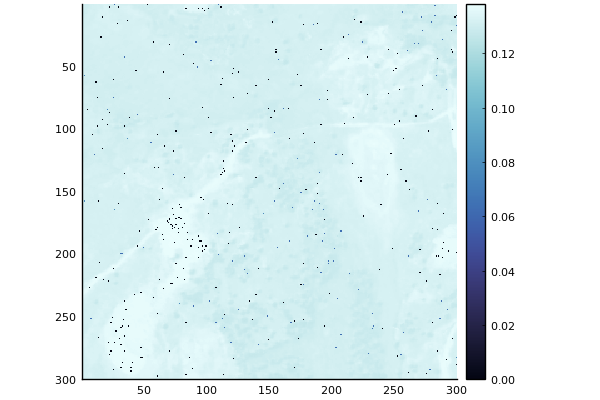

In [58]:
#visualize a spectral band on its own
sb = 10
p2 = heatmap(img[:,:,sb],aspect_ratio=1, yflip = true,c=:ice)

In [59]:
function generate_rgb_img(img)
    rgb = zeros(size(img,1),size(img,2),3)  
    rgb[:,:,3] = img[:,:,67] * 1.3520674485645392; 
    rgb[:,:,2] = img[:,:,109] * 1.194526746571833;
    rgb[:,:,1] = img[:,:,141] * 1.092957082800559; 
    return rgb
end

generate_rgb_img (generic function with 1 method)

In [60]:
img_rgb = generate_rgb_img(img);

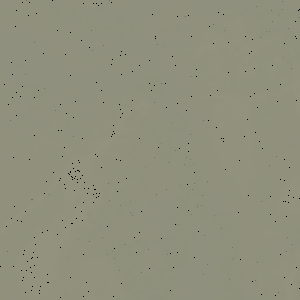

In [61]:
colorview(RGB,permutedims(img_rgb,(3,1,2)))